# Grid search and feature engineering
Follow _Data Science Handbook_ Ch. 5 [Feature Engineering](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.04-Feature-Engineering.ipynb) (p.373-382)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Validation in practice: Grid search

Cross-validation can be used to explore a grid of Hyperparameters to the model/pipline. In grid search, every combination of parameters in the parameter grid is explored.

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [3]:
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

Building the grid search:

In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

calling `fit()` will perform the search

In [5]:
grid.fit(X, y);

The output is the set of parameters with the highest average cross-validation score:

In [6]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

There is a model with these parameters available too. Notice that this model is (re-)trained on all of the data.

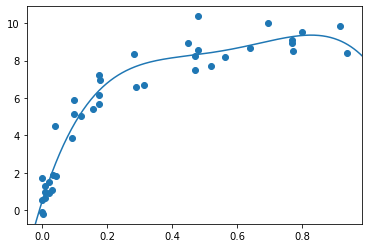

In [7]:
model = grid.best_estimator_

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

In practice, there would probably be a test dataset, untouched by the model selection and training process, only used to assess model performance prior to shipping to the client.

## Feature engineering - PCA 
When we have many features, we might want to reduced the number of features. PCA provides a way to create new features capturing most variance.

From `w02-1.ipynb` load and prepare iris

In [8]:
iris = sns.load_dataset('iris')
X_iris = iris.drop('species', axis=1)
print(X_iris.shape)
y_iris = iris['species']
print(y_iris.shape)

(150, 4)
(150,)


From `w02-1.ipynb` get the iris PCA

In [9]:
from sklearn.decomposition import PCA
model = PCA(n_components=2)
model.fit(X_iris)
X_2D = model.transform(X_iris)

From `w02-1.ipynb` get the iris classification

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, random_state=1)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.9736842105263158

**Question:** Refactor the above code into a function `get_model_accuracy(X, y)` that returns the `accuracy_score`.

Now compare original vs PCA (2) performance

In [12]:
print('GaussianNB using all features: {}'.format(get_model_accuracy(X_iris, y_iris)))
print('GaussianNB using 2 principal components: {}'.format(get_model_accuracy(X_2D, y_iris)))

GaussianNB using all features: 0.9736842105263158
GaussianNB using 2 principal components: 0.9473684210526315


**Question:** Can you change the function `get_model_accuracy()` to have `model` as a parameter and test different models?

0.9736842105263158

**Question:** Can you create a function that takes a feature matrix `X` as argument and returns a feature matrix with the first `n` principal components?

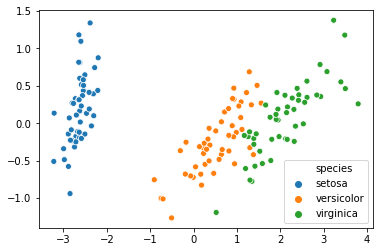

**Question:** Are there other ways to refactor/extend the code?

GaussianNB using all features: 0.9736842105263158
GaussianNB using 2 principal components: 0.9473684210526315
LogisticRegression using all features: 0.9736842105263158
LogisticRegression using 2 principal components: 0.9736842105263158


/Users/pauc/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Feature engineering - categorical features

While it is ok to have your target vector in classification represent categories as strings for example, categorical features need to be transformed in _scikit-learn_.

There are two major types:
1. Ordinal use `OrdinalEncoder`
2. Nominal use `OneHotEncoder` (can handle non-string features, `DictVectorizer()` cannot)

**Question:** What is the difference between ordinal and nominal features? Can you give examples?

**Answer:** ...

In [16]:
data = pd.DataFrame([
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
])

In [17]:
data

,price,rooms,neighborhood
0,850000,4,Queen Anne
1,700000,3,Fremont
2,650000,3,Wallingford
3,600000,2,Fremont


### OrdinalEncoder
**IMPORTANT:** Neighborhoods are _nominal_ and should not be encoded with an OrdinalEncoder. We do this here only for comparison to One-Hot Encoder.

In [18]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(data[['neighborhood']])

OrdinalEncoder()

In [19]:
enc.categories_

[array(['Fremont', 'Queen Anne', 'Wallingford'], dtype=object)]

In [20]:
enc.transform(data[['neighborhood']])

array([[1.],
       [0.],
       [2.],
       [0.]])

In [21]:
enc.inverse_transform([[1]])

array([['Queen Anne']], dtype=object)

### OneHotEncoder 

In [22]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc.fit(data[['neighborhood']])

OneHotEncoder(sparse=False)

In [23]:
enc.get_feature_names()

array(['x0_Fremont', 'x0_Queen Anne', 'x0_Wallingford'], dtype=object)

In [24]:
enc.transform(data[['neighborhood']])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [25]:
data_enc = pd.DataFrame(enc.transform(data[['neighborhood']]), columns=enc.get_feature_names())
data_enc

,x0_Fremont,x0_Queen Anne,x0_Wallingford
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0


**Question:** Can you add `data_enc` to the original `data`, dropping the `'neighborhood'` column?

In [26]:
data.head()

,price,rooms,neighborhood
0,850000,4,Queen Anne
1,700000,3,Fremont
2,650000,3,Wallingford
3,600000,2,Fremont


,price,rooms,x0_Fremont,x0_Queen Anne,x0_Wallingford
0,850000,4,0.0,1.0,0.0
1,700000,3,1.0,0.0,0.0
2,650000,3,0.0,0.0,1.0
3,600000,2,1.0,0.0,0.0


In practice, we would use `ColumnTransformer` in a pipeline. We will see this later.

## Pipelines 

We can stack various pre-processing and the actual model in a pipeline.

For example, if all features were nominal (categorical without order), we could stack a `OneHotEncoder()` followed by a classifier, e.g. `LogisticRegression()`.

Conversion of the features happens under the hood.

In [28]:
X = np.array([
    ['sunny', 'summer'],
    ['rainy', 'summer'],
    ['rainy', 'fall'],
    ['cloudy', 'winter'],
    ['very rainy', 'spring'],
    ['sunny', 'winter'],
    ['partially cloudy', 'spring']
])

y = np.array([
    'T-shirt',
    'T-shirt',
    'Coat',
    'Coat',
    'Coat',
    'Coat',
    'T-shirt'
])

In [29]:
X.shape

(7, 2)

In [30]:
y.shape

(7,)

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

model = make_pipeline(OneHotEncoder(),
                      LogisticRegression())

In [32]:
model.fit(X, y)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('logisticregression', LogisticRegression())])

In [33]:
model.score(X, y)

1.0

In [34]:
model.predict([['cloudy', 'spring']])

array(['Coat'], dtype='<U7')

We can setup the same pipeline with an `OrdinalEncoder()`. However, these featuers do not have order (so we should not!).

In [35]:
model = make_pipeline(OrdinalEncoder(),
                      LogisticRegression())
model.fit(X, y)
model.score(X, y)

0.5714285714285714

In [36]:
model.predict([['cloudy', 'spring']])

array(['T-shirt'], dtype='<U7')

We get a different answer. Note that Decision Tree methods might be less susceptible to this.